# Klasifikasi Gambar
---

In [1]:
import os
from tqdm import tqdm

## 0. Global Function and Variables

In [2]:
DATA_DIR = "./data"
RAW_DIR = os.path.join(DATA_DIR, "raw_img")
TRAIN_DIR = os.path.join(DATA_DIR, "train")
TEST_DIR = os.path.join(DATA_DIR, "test")
VALIDATION_DIR = os.path.join(DATA_DIR, "val")

In [34]:
def inspect_dir(path):
    for root, dirs, files in os.walk(path):
        file_count = len([f for f in files if os.path.isfile(os.path.join(root, f))])
        print(f"{root} -> {file_count} files")

    total_files = sum(len(files) for _, _, files in os.walk(path))
    print(f"\nTotal files: {total_files}")

## 1. Read Image Dataset

In [35]:
from PIL import Image
import matplotlib.pyplot as plt
%pwd

'/home/jovyan/wmr/laskar-ai/klasifikasi_gambar/submission'

In [36]:
inspect_dir(RAW_DIR)

./data/raw_img -> 0 files
./data/raw_img/dog -> 4863 files
./data/raw_img/chicken -> 3098 files
./data/raw_img/spider -> 4821 files

Total files: 12782


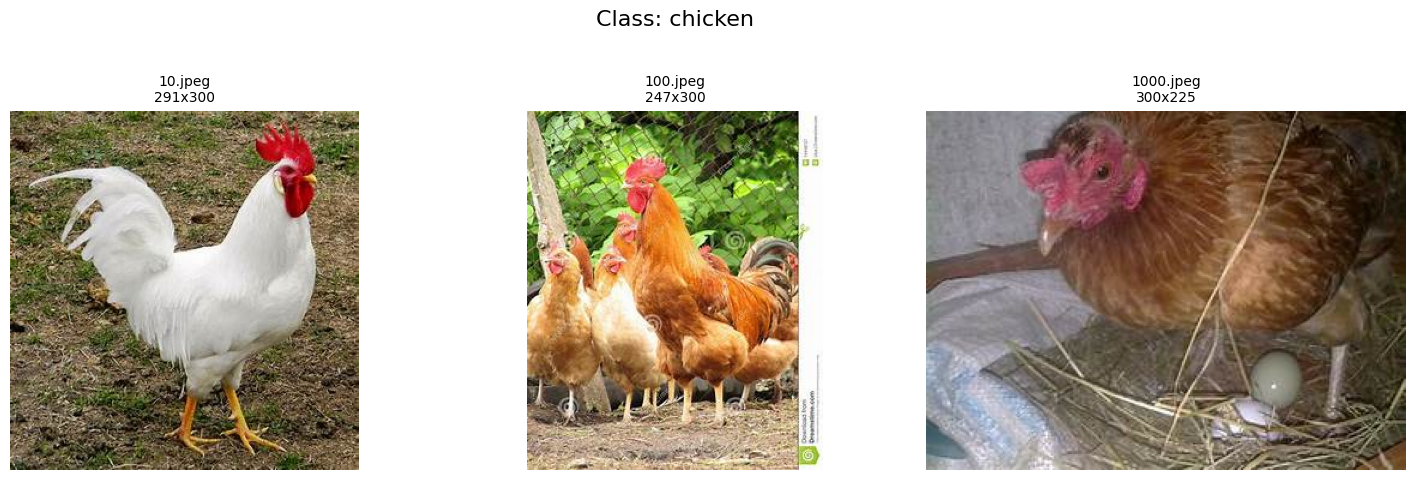

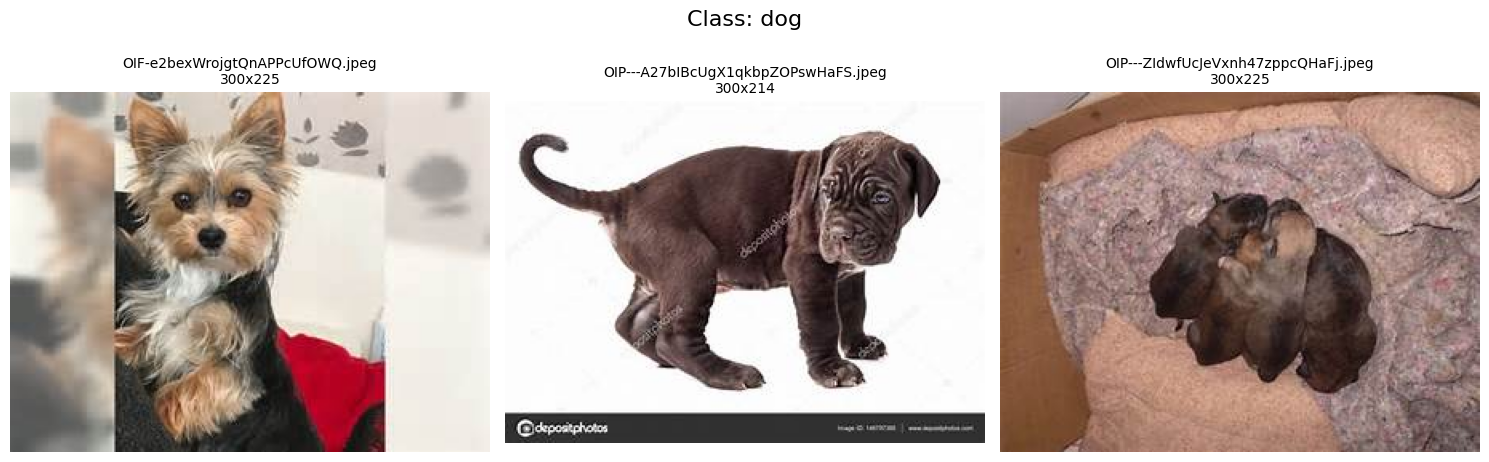

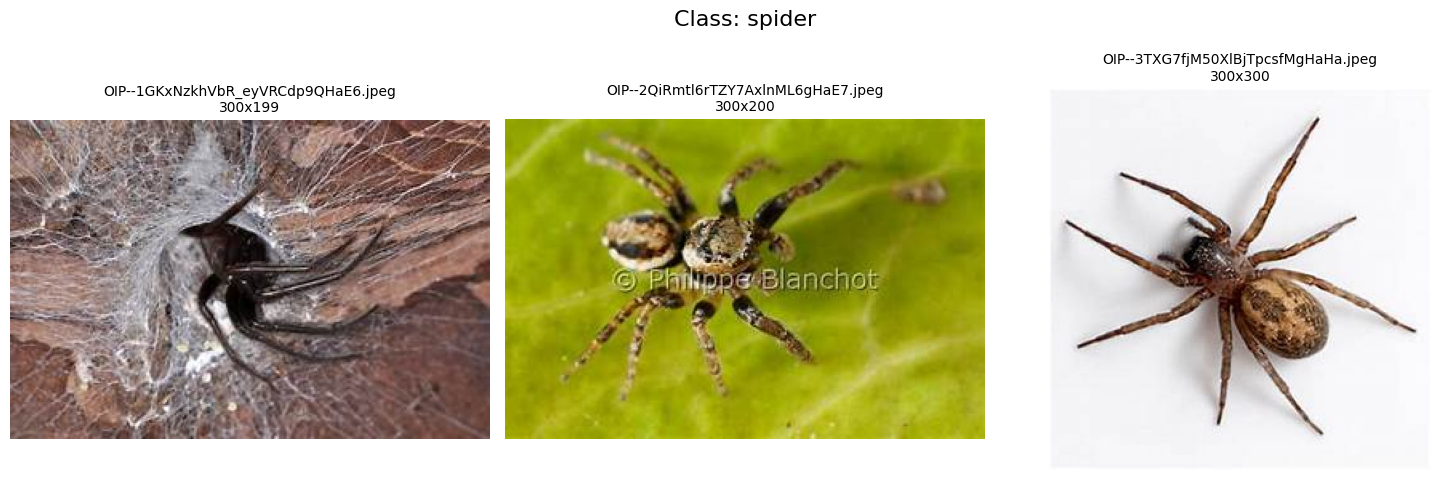

In [37]:
for class_name in sorted(os.listdir(RAW_DIR)):
    class_path = os.path.join(RAW_DIR, class_name)
    if not os.path.isdir(class_path):
        continue

    # Get up to 3 image files
    image_files = [f for f in os.listdir(class_path)
                   if os.path.isfile(os.path.join(class_path, f)) and f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    sample_images = image_files[:3]
    if not sample_images:
        continue

    # Plot
    fig, axes = plt.subplots(1, len(sample_images), figsize=(15, 5))
    fig.suptitle(f"Class: {class_name}", fontsize=16)

    if len(sample_images) == 1:
        axes = [axes]

    for ax, img_name in zip(axes, sample_images):
        img_path = os.path.join(class_path, img_name)
        img = Image.open(img_path)
        width, height = img.size
        ax.imshow(img)
        ax.set_title(f"{img_name}\n{width}x{height}", fontsize=10)
        ax.axis('off')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

## 2. Preprocessing

### 2.1. Split Train, Test, and Validation

In [38]:
import os
import shutil
import random

In [39]:
SPLIT_RATIOS = (0.8, 0.1, 0.1)  # train, val, test

for split in ['train', 'val', 'test']:
    for class_name in os.listdir(RAW_DIR):
        class_dir = os.path.join(RAW_DIR, class_name)
        if os.path.isdir(class_dir):
            os.makedirs(os.path.join(DATA_DIR, split, class_name), exist_ok=True)

for class_name in os.listdir(RAW_DIR):
    class_path = os.path.join(RAW_DIR, class_name)
    if not os.path.isdir(class_path):
        continue

    images = [f for f in os.listdir(class_path)
              if os.path.isfile(os.path.join(class_path, f)) and f.lower().endswith(('.jpg', '.png', '.jpeg'))]
    random.shuffle(images)

    n_total = len(images)
    n_train = int(n_total * SPLIT_RATIOS[0])
    n_val = int(n_total * SPLIT_RATIOS[1])
    n_test = n_total - n_train - n_val

    splits = {
        'train': images[:n_train],
        'val': images[n_train:n_train + n_val],
        'test': images[n_train + n_val:]
    }

    for split_name, files in splits.items():
        for file in tqdm(files, desc=f"{class_name} -> {split_name}", leave=True):
            src = os.path.join(class_path, file)
            dst = os.path.join(DATA_DIR, split_name, class_name, file)
            shutil.copy2(src, dst)

print("✅ Dataset split completed!")

spider -> test: 100%|██████████| 483/483 [00:01<00:00, 376.45it/s]

✅ Dataset split completed!


In [40]:
inspect_dir(TRAIN_DIR)
print("="*50)
inspect_dir(VALIDATION_DIR)
print("="*50)
inspect_dir(TEST_DIR)

./data/train -> 0 files
./data/train/dog -> 3890 files
./data/train/chicken -> 2478 files
./data/train/spider -> 3856 files

Total files: 10224
./data/val -> 0 files
./data/val/dog -> 486 files
./data/val/chicken -> 309 files
./data/val/spider -> 482 files

Total files: 1277
./data/test -> 0 files
./data/test/dog -> 487 files
./data/test/chicken -> 311 files
./data/test/spider -> 483 files

Total files: 1281


### 2.2. Create Data Generator

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

2025-05-28 19:32:10.088647: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-28 19:32:10.122407: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9373] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-05-28 19:32:10.122432: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-05-28 19:32:10.123696: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1534] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-28 19:32:10.129884: I tensorflow/core/platform/cpu_feature_guar

* **Data Augmentation**

In [4]:
train_datagen = ImageDataGenerator(
    rescale=1/255,
    rotation_range=15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [5]:
validation_datagen = ImageDataGenerator(rescale=1/255)

In [6]:
test_datagen = ImageDataGenerator(rescale=1/255)

* **Image Data Generator**

In [7]:
train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(300, 300),
    batch_size=32,
    class_mode='categorical'
)

Found 10224 images belonging to 3 classes.


In [8]:
validation_generator = validation_datagen.flow_from_directory(
    VALIDATION_DIR,
    target_size=(300, 300),
    batch_size=32,
    class_mode='categorical'
)

Found 1277 images belonging to 3 classes.


In [9]:
test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=(300, 300),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

Found 1281 images belonging to 3 classes.


## 3. Modeling

In [10]:
!nvidia-smi

Wed May 28 19:32:17 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.90.07              Driver Version: 550.90.07      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA H100 80GB HBM3          On  |   00000000:C0:00.0 Off |                    0 |
| N/A   28C    P0             69W /  700W |       1MiB /  81559MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [11]:
import tensorflow as tf
from tensorflow import keras
import keras_tuner as kt

### 3.1. Define the Model

In [20]:
def model_builder(hp):
    model = keras.Sequential()
    
    model.add(keras.layers.Conv2D(
        filters=hp.Int('conv1_filters', min_value=16, max_value=64, step=16),
        kernel_size=(3, 3),
        activation='relu',
        input_shape=(300, 300, 3)
    ))
    model.add(keras.layers.MaxPooling2D(2, 2))
    
    model.add(keras.layers.Conv2D(
        filters=hp.Int('conv2_filters', min_value=32, max_value=128, step=32),
        kernel_size=(3, 3),
        activation='relu'
    ))
    model.add(keras.layers.MaxPooling2D(2, 2))
    
    model.add(keras.layers.Conv2D(
        filters=hp.Int('conv3_filters', min_value=64, max_value=128, step=32),
        kernel_size=(3, 3),
        activation='relu'
    ))
    model.add(keras.layers.MaxPooling2D(2, 2))
    
    model.add(keras.layers.Conv2D(
        filters=hp.Int('conv4_filters', min_value=64, max_value=128, step=32),
        kernel_size=(3, 3),
        activation='relu'
    ))
    model.add(keras.layers.MaxPooling2D(2, 2))
    
    model.add(keras.layers.Conv2D(
        filters=hp.Int('conv5_filters', min_value=64, max_value=128, step=32),
        kernel_size=(3, 3),
        activation='relu'
    ))
    model.add(keras.layers.MaxPooling2D(2, 2))
    
    model.add(keras.layers.Flatten())
    
    model.add(keras.layers.Dense(
        units=hp.Int('dense_units', min_value=256, max_value=1024, step=128),
        activation='relu'
    ))
    
    model.add(keras.layers.Dense(3, activation='softmax'))
    
    lr = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=lr),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

### 3.2. Hyperparameter Tuning

In [21]:
tuner = kt.Hyperband(
    model_builder,
    objective='val_accuracy',
    max_epochs=10,
    factor=3,
    directory='tuner',
    project_name='conv_tuning'
)

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [22]:
tuner.search(train_generator, epochs=50, validation_data=validation_generator, callbacks=[stop_early])

Trial 30 Complete [00h 17m 38s]
val_accuracy: 0.8989819884300232

Best val_accuracy So Far: 0.916209876537323
Total elapsed time: 03h 32m 30s


In [23]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(best_hps.values)

{'conv1_filters': 16, 'conv2_filters': 64, 'conv3_filters': 128, 'conv4_filters': 64, 'conv5_filters': 96, 'dense_units': 384, 'learning_rate': 0.001, 'tuner/epochs': 10, 'tuner/initial_epoch': 4, 'tuner/bracket': 1, 'tuner/round': 1, 'tuner/trial_id': '0018'}


### 3.3. Train the Model

In [48]:
from tensorflow.keras import backend as K
K.clear_session()

In [49]:
model = tuner.hypermodel.build(best_hps)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 298, 298, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 149, 149, 16)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 147, 147, 64)      9280      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 73, 73, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 71, 71, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 35, 35, 128)       0

In [50]:
class ConditionalEarlyStopping(tf.keras.callbacks.Callback):
    def __init__(self, accuracy_threshold=0.95, patience=10):
        super().__init__()
        self.accuracy_threshold = accuracy_threshold
        self.patience = patience
        self.wait = 0
        self.best_val_accuracy = -float('inf')
        self.best_weights = None
        self.stop_training_enabled = False
        self.best_loss = float('inf')

    def on_epoch_end(self, epoch, logs=None):
        train_acc = logs.get("accuracy") 
        val_acc = logs.get("val_accuracy")
        val_loss = logs.get("val_loss")

        if train_acc is None or val_acc is None or val_loss is None:
            return

        if val_acc > self.best_val_accuracy:
            self.best_val_accuracy = val_acc
            self.best_weights = self.model.get_weights()

        if not self.stop_training_enabled:
            if train_acc >= self.accuracy_threshold and val_acc >= self.accuracy_threshold:
                print(f"\nTraining and validation accuracy both reached {self.accuracy_threshold * 100:.2f}%. EarlyStopping on val_loss is now active.")
                self.stop_training_enabled = True
                self.wait = 0
                self.best_loss = val_loss
        else:
            if val_loss < self.best_loss:
                self.best_loss = val_loss
                self.wait = 0
            else:
                self.wait += 1
                print(f"\nval_loss did not improve. Wait counter: {self.wait}/{self.patience}")
                if self.wait >= self.patience:
                    print(f"\nEarlyStopping triggered. Restoring best weights (val_accuracy: {self.best_val_accuracy:.4f}).")
                    self.model.set_weights(self.best_weights)
                    self.model.stop_training = True


In [51]:
stop_early = ConditionalEarlyStopping(accuracy_threshold=0.95, patience=10)

history = model.fit(train_generator, epochs=100, validation_data=validation_generator, callbacks=[stop_early])

Epoch 1/100
320/320 [==============================] - 105s 325ms/step - loss: 1.0165 - accuracy: 0.4602 - val_loss: 0.8407 - val_accuracy: 0.6163
Epoch 2/100
320/320 [==============================] - 105s 328ms/step - loss: 0.7830 - accuracy: 0.6617 - val_loss: 0.6418 - val_accuracy: 0.7345
Epoch 3/100
320/320 [==============================] - 105s 327ms/step - loss: 0.6440 - accuracy: 0.7428 - val_loss: 0.5014 - val_accuracy: 0.8066
Epoch 4/100
320/320 [==============================] - 104s 325ms/step - loss: 0.5683 - accuracy: 0.7817 - val_loss: 0.4248 - val_accuracy: 0.8348
Epoch 5/100
320/320 [==============================] - 105s 328ms/step - loss: 0.4936 - accuracy: 0.8118 - val_loss: 0.3911 - val_accuracy: 0.8567
Epoch 6/100
320/320 [==============================] - 104s 326ms/step - loss: 0.4459 - accuracy: 0.8326 - val_loss: 0.3544 - val_accuracy: 0.8669
Epoch 7/100
320/320 [==============================] - 104s 325ms/step - loss: 0.3985 - accuracy: 0.8525 - val_loss: 0

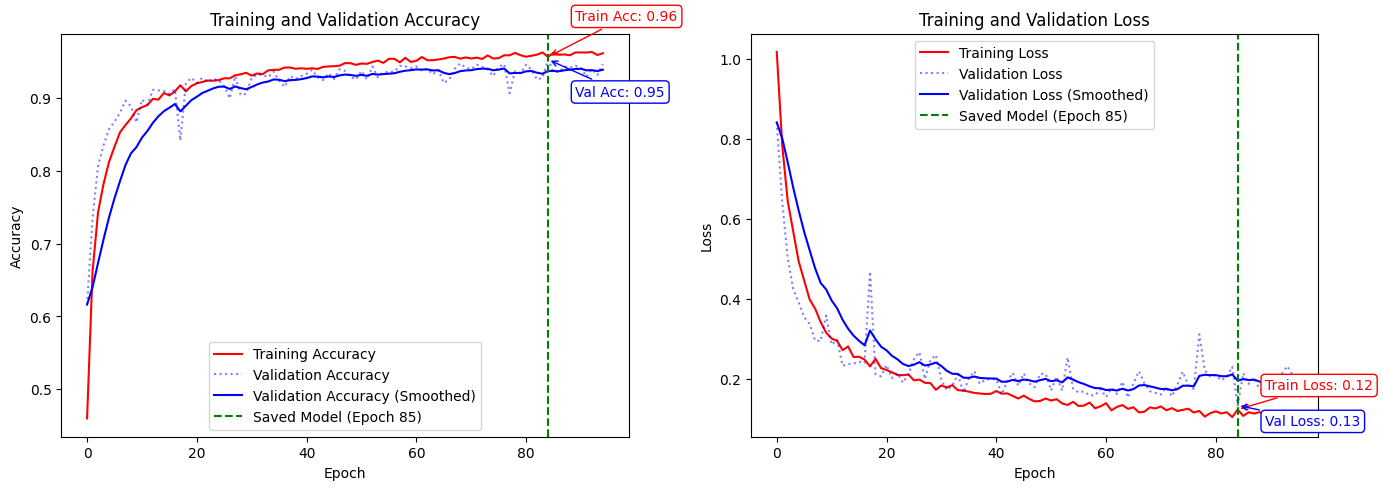

In [88]:
import matplotlib.pyplot as plt
import numpy as np

def smooth_curve(points, factor=0.8):
    smoothed = []
    for point in points:
        if smoothed:
            smoothed.append(smoothed[-1] * factor + point * (1 - factor))
        else:
            smoothed.append(point)
    return smoothed

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

val_acc_smooth = smooth_curve(val_acc)
val_loss_smooth = smooth_curve(val_loss)

epochs = range(len(acc))
cutoff_epoch = 84

acc_at_cutoff = acc[cutoff_epoch]
val_acc_at_cutoff = val_acc[cutoff_epoch]
loss_at_cutoff = loss[cutoff_epoch]
val_loss_at_cutoff = val_loss[cutoff_epoch]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.plot(epochs, acc, 'r', label='Training Accuracy')
ax1.plot(epochs, val_acc, 'b:', alpha=0.5, label='Validation Accuracy')
ax1.plot(epochs, val_acc_smooth, 'b', label='Validation Accuracy (Smoothed)')
ax1.axvline(x=cutoff_epoch, color='g', linestyle='--', label='Saved Model (Epoch 85)')

ax1.annotate(f'Train Acc: {acc_at_cutoff:.2f}', xy=(cutoff_epoch, acc_at_cutoff),
             xytext=(cutoff_epoch + 5, acc_at_cutoff + 0.05),
             fontsize=10, color='r',
             bbox=dict(boxstyle="round,pad=0.3", edgecolor='r', facecolor='white'),
             arrowprops=dict(arrowstyle='->', color='r'))

ax1.annotate(f'Val Acc: {val_acc_at_cutoff:.2f}', xy=(cutoff_epoch, val_acc_at_cutoff),
             xytext=(cutoff_epoch + 5, val_acc_at_cutoff - 0.05),
             fontsize=10, color='b',
             bbox=dict(boxstyle="round,pad=0.3", edgecolor='b', facecolor='white'),
             arrowprops=dict(arrowstyle='->', color='b'))

ax1.set_title('Training and Validation Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend()

ax2.plot(epochs, loss, 'r', label='Training Loss')
ax2.plot(epochs, val_loss, 'b:', alpha=0.5, label='Validation Loss')
ax2.plot(epochs, val_loss_smooth, 'b', label='Validation Loss (Smoothed)')
ax2.axvline(x=cutoff_epoch, color='g', linestyle='--', label='Saved Model (Epoch 85)')

ax2.annotate(f'Train Loss: {loss_at_cutoff:.2f}', xy=(cutoff_epoch, loss_at_cutoff),
             xytext=(cutoff_epoch + 5, loss_at_cutoff + 0.05),
             fontsize=10, color='r',
             bbox=dict(boxstyle="round,pad=0.3", edgecolor='r', facecolor='white'),
             arrowprops=dict(arrowstyle='->', color='r'))

ax2.annotate(f'Val Loss: {val_loss_at_cutoff:.2f}', xy=(cutoff_epoch, val_loss_at_cutoff),
             xytext=(cutoff_epoch + 5, val_loss_at_cutoff - 0.05),
             fontsize=10, color='b',
             bbox=dict(boxstyle="round,pad=0.3", edgecolor='b', facecolor='white'),
             arrowprops=dict(arrowstyle='->', color='b'))

ax2.set_title('Training and Validation Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()

plt.tight_layout()
plt.show()

### 3.4. Evaluation (Test Set)

In [73]:
from sklearn.metrics import classification_report

y_true = test_generator.classes
y_pred_probs = model.predict(test_generator)
y_pred = np.argmax(y_pred_probs, axis=1)

print(classification_report(y_true, y_pred, target_names=test_generator.class_indices.keys()))

41/41 [==============================] - 2s 57ms/step
              precision    recall  f1-score   support

     chicken       0.93      0.92      0.93       311
         dog       0.96      0.93      0.94       487
      spider       0.95      0.97      0.96       483

    accuracy                           0.95      1281
   macro avg       0.94      0.94      0.94      1281
weighted avg       0.95      0.95      0.95      1281



The trained image classification model on a held-out test set containing 1,281 images across three classes: chicken, dog, and spider. The model demonstrates **high overall performance** with a classification **accuracy of 95%**. A closer look at class-wise metrics reveals the following:

* The model performs **consistently well across all categories**, with F1-scores ranging from **93% to 96%**.
* The **"Spider" class** achieved the **highest recall (97%)**, indicating the model is highly effective at identifying spiders without missing many instances.
* The **"Dog" class** has the **highest precision (96%)**, suggesting that when the model predicts "dog," it is almost always correct.
* The **balanced precision and recall** in all classes indicate **no major bias** toward any particular category.
* The **macro and weighted averages** confirm the model maintains **uniform performance**, regardless of class imbalance.

### 3.5. Save the Model and Training History

In [97]:
SAVEDMODEL_DIR = os.path.join("saved_model")
TFJS_DIR = os.path.join("tfjs_model")
TFLITE_DIR = os.path.join("tflite")

In [74]:
import json

with open('history.json', 'w') as f:
    json.dump(history.history, f)

In [108]:
class_indices = train_generator.class_indices

labels_dict = {str(index): label for label, index in class_indices.items()}

with open('labels.json', 'w') as f:
    json.dump(labels_dict, f, indent=2)

#### 3.5.1. SavedModel Format

In [75]:
model.save(SAVEDMODEL_DIR)

INFO:tensorflow:Assets written to: saved_model/assets


INFO:tensorflow:Assets written to: saved_model/assets


#### 3.5.2. TensorFlow.js Format

In [ ]:
!pip install tensorflowjs

In [96]:
!python3 -m tensorflowjs.converters.converter \
  --input_format=tf_saved_model \
  --output_node_names='Animal-3' \
  --saved_model_tags=serve \
  saved_model \
  tfjs_model

2025-05-29 06:55:58.044499: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748501758.058175  518468 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748501758.062068  518468 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1748501758.072481  518468 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1748501758.072498  518468 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1748501758.072500  518468 computation_placer.cc:177] computation placer alr

#### 3.5.3. TFLite Format

* **Create calibration data for post-training quantization**

In [100]:
calibration_datagen = ImageDataGenerator(rescale=1./255)

calibration_generator = calibration_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(300, 300),
    batch_size=1,
    class_mode='categorical',
    shuffle=True
)


def representative_dataset():
    for i in range(300):
        image, _ = calibration_generator.next()
        yield [image.astype(np.float32)]

Found 10224 images belonging to 3 classes.


* **Convert the model**

In [101]:
converter = tf.lite.TFLiteConverter.from_saved_model(SAVEDMODEL_DIR)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_dataset

converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.uint8
converter.inference_output_type = tf.uint8

tflite_qt_model = converter.convert()

2025-05-29 07:23:06.530112: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2025-05-29 07:23:06.530141: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2025-05-29 07:23:06.531080: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: saved_model
2025-05-29 07:23:06.532917: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2025-05-29 07:23:06.532928: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: saved_model
2025-05-29 07:23:06.538737: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:388] MLIR V1 optimization pass is not enabled
2025-05-29 07:23:06.539923: I tensorflow/cc/saved_model/loader.cc:235] Restoring SavedModel bundle.
2025-05-29 07:23:06.610170: I tensorflow/cc/saved_model/loader.cc:219] Running initialization op on SavedModel bundle at path: saved_model
2025-05-29 07:23:06.62

* **Save the Quantized TFLite model**

In [102]:
with open(os.path.join(TFLITE_DIR, "model_qt.tflite"), 'wb') as f:
  f.write(tflite_qt_model)

## 4. Inference

In [118]:
import tensorflow as tf
import numpy as np
import requests
import json
import time
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import img_to_array

class TFLiteImageClassifier:
    def __init__(self, model_path, class_json_path, image_size=(300, 300)):
        self.image_size = image_size
        self.class_names = self.__load_class_names(class_json_path)
        
        self.interpreter = tf.lite.Interpreter(model_path=model_path)
        self.interpreter.allocate_tensors()
        
        self.input_details = self.interpreter.get_input_details()
        self.output_details = self.interpreter.get_output_details()
        self.input_dtype = self.input_details[0]['dtype']
        print("Model loaded. Input dtype:", self.input_dtype)

    def __load_class_names(self, class_json_path):
        with open(class_json_path, 'r') as f:
            class_dict = json.load(f)
        return [class_dict[str(i)] for i in sorted(map(int, class_dict.keys()))]

    def __load_image_from_url(self, url):
        response = requests.get(url)
        img = Image.open(BytesIO(response.content)).convert('RGB')
        img = img.resize(self.image_size)
        return img

    def __preprocess_image(self, img):
        img_array = img_to_array(img)
        img_array = img_array / 255.0
        img_array = np.expand_dims(img_array, axis=0)
        if self.input_dtype == np.uint8:
            img_array = (img_array * 255).astype(np.uint8)
        else:
            img_array = img_array.astype(self.input_dtype)
        return img_array

    def predict(self, image_urls):
        if isinstance(image_urls, str):
            image_urls = [image_urls]

        for url in image_urls:
            img = self.__load_image_from_url(url)
            input_tensor = self.__preprocess_image(img)

            start_time = time.time()
            self.interpreter.set_tensor(self.input_details[0]['index'], input_tensor)
            self.interpreter.invoke()
            inference_time = (time.time() - start_time) * 1000  # milliseconds

            output = self.interpreter.get_tensor(self.output_details[0]['index'])

            predicted_index = np.argmax(output)
            predicted_label = self.class_names[predicted_index]
            confidence = np.max(output)

            self.__display_result(img, predicted_label, confidence, inference_time)

    def __display_result(self, img, label, confidence, inference_time):
        plt.imshow(img)
        plt.axis('off')
        plt.title(f"Prediction: {label} ({confidence:.2f})\nInference time: {inference_time:.1f} ms")
        plt.show()

In [119]:
classifier = TFLiteImageClassifier("tflite/model_qt.tflite", "labels.json")

Model loaded. Input dtype: <class 'numpy.uint8'>


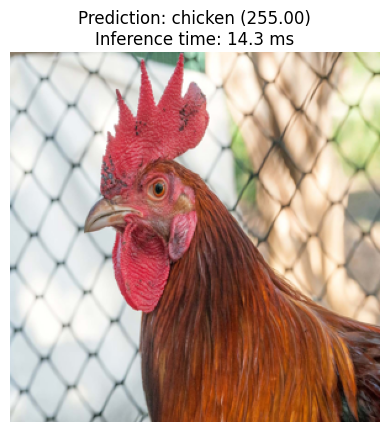

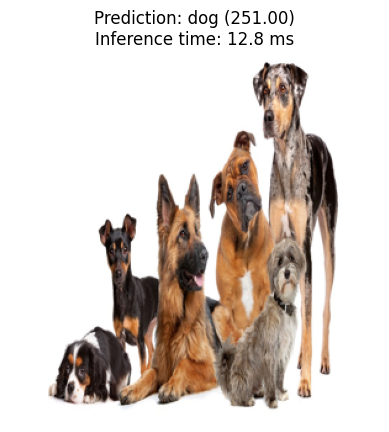

In [120]:
classifier.predict(["https://cdn.britannica.com/07/183407-050-C35648B5/Chicken.jpg",
                    "https://vitapet.com/media/kczlgn0r/dog-breed-temperaments-1240x640.jpg?anchor=center&mode=crop&width=1240&rnd=133155369200630000"
                   ])